In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.animation as animation

import astropy.units as u
import astropy.constants as const
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, SkyOffsetFrame


from scipy.sparse.linalg import eigsh
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
from scipy.sparse.linalg import svds


import time as timer

from pint.models import get_model
from RickettTables import fitvals
from RickettEquations import *
from Curvature import *

import scintools2.scintools.ththmod as thth
from scintools2.scintools.dynspec import BasicDyn, Dynspec



import gc
from multiprocessing import Pool
from tqdm.notebook import tqdm

import warnings

warnings.filterwarnings("ignore", message="divide by zero encountered in divide")
biharmonic = False

In [2]:
from Funcs_DP import *
from Funcs_DP_Orbsim import *
from Funcs_DP_Sspec import *

In [3]:
dspec = np.load( "/mnt/scratch-lustre/dbaker/GB057/dspec_arar.npz")

#select only the last 3000 elements
freq_selector = [-3001,-1]

ts = (dspec['time']* u.s ).to(u.hour)
fs = dspec['freq'][freq_selector[0]:freq_selector[1]] * u.MHz
ds = dspec['ds'][freq_selector[0]:freq_selector[1]]

Text(0.5, 1.0, 'Dynamic Spectrum')

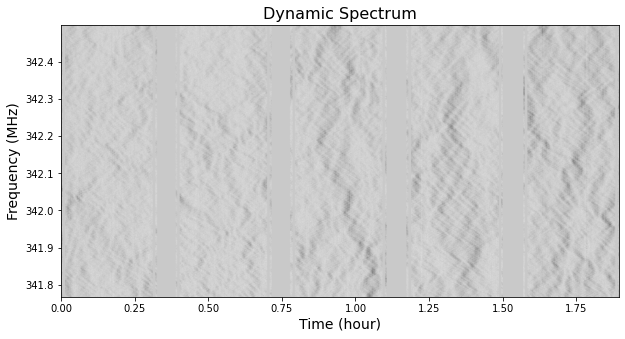

In [4]:
plt.figure(figsize=(10,5))
plt.imshow(ds,
           origin='lower',
           aspect = 'auto',
#            interpolation = None,
           vmin = np.min(ds),
           extent=ext_find(ts.to(u.hour), fs),
          cmap = 'gray_r' )
plt.xlabel("Time (hour)", fontsize = 14)
plt.ylabel('Frequency (MHz)', fontsize = 14)
plt.title("Dynamic Spectrum", fontsize = 16)

## Steps to mimic a double pulsar dynamic spectrum

In [5]:
Om = 6.944 * (1/u.hour)
A = 6.0
c = -2.3

nu_asc = 1.4 * u.rad


#induce the mirrored versions of the dynamic spectrum
ds_orb, ts_orb = induce_mirror_motion( t = ts.to(u.hour), 
                                      nu = (ts.to(u.hour) * Om).value * u.rad - nu_asc,
                                      dyn = ds, 
                                      A = A, 
                                      phi = (ts.to(u.hour) * Om).value * u.rad, 
                                      c = c)

#induce orbital motion
tres2, dres2, res_t1, res_pos1, res_dyn1, res_tau1, res_fd1, res_CS1 = create_orbital_dynamic_spectrum( A = A, 
                                                                                                       c = c, 
                                                                                                       Om = Om,
                                                                                                       nu = (ts_orb.to(u.hour) * Om).value * u.rad - nu_asc,
                                                                                                       t = ts_orb, 
                                                                                                       f = fs, 
                                                                                                       dyn = ds_orb, 
                                                                                                       dt = 0.2)


#getting peaks and an artificial orbital phase 
phases = (tres2.to(u.hour) * Om).value * u.rad
nues = (tres2.to(u.hour) * Om).value * u.rad - nu_asc

peaksres = peaks(Ad_projection_unitless((tres2.to(u.hour)).value, 
                                        nues,
                                       phases,
                                       A,
                                       c))[0]

Text(0.5, 0, 'Time (hours)')

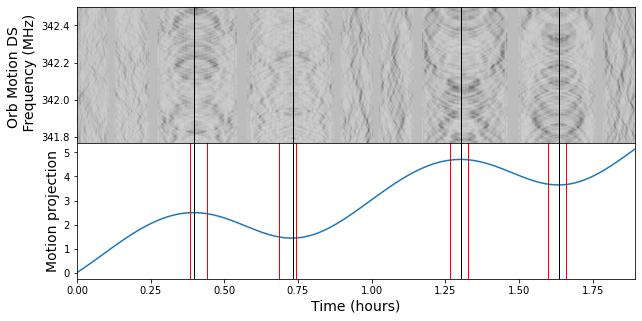

In [6]:
a_guess = tres2[peaksres].to(u.hour).value + (np.random.rand(peaksres.shape[0]) - 0.5) * (0.05)
plt.figure(figsize = (10,5))
plt.subplot(2,1,1)

plt.imshow(dres2,
           origin='lower',
           aspect = 'auto',
#            interpolation = None,
           vmin = np.min(dres2),
           extent=ext_find(tres2.to(u.hour), fs),
          cmap = 'gray_r' )

for i in range(len( peaksres) ):
    plt.axvline(x=tres2[peaksres[i]].to(u.hour).value, c='k', lw = 1.)
plt.xticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.ylabel("Orb Motion DS \n Frequency (MHz)", fontsize = 14)

plt.subplot(2,1,2)


plt.plot(tres2, Ad_projection_unitless((tres2.to(u.hour)).value, 
                                       nues,
                                       (tres2.to(u.hour) * Om).value * u.rad,
                                       A,
                                       c))
plt.xlim(0, np.max(tres2.value))
atol = 0.03
for i in range(len( peaksres) ):
    plt.axvline(x=tres2[peaksres[i]].to(u.hour).value, c='k', lw = 1.)
    plt.axvline(x=a_guess[i] + atol, c='r', lw = 1.)
    plt.axvline(x=a_guess[i] - atol, c='r', lw = 1.)

plt.ylabel('Motion projection', fontsize = 14)
plt.xlabel('Time (hours)', fontsize =14)

## Parameter space searcher

29.0


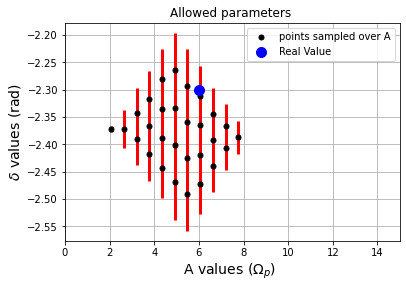

In [15]:
dyn_noise = dres2

a_guess = tres2[peaksres].to(u.hour).value + (np.random.rand(peaksres.shape[0]) - 0.5) * (0.05)
atol = 0.03

phase_storage = []
A_storage = []

#assign a limit for the range of A (the part below can be skipped if you know the range of A_multipliers)
randy1 = (np.random.rand(1) - 0.5)*2 * 2
randy2 = (np.random.rand(1) - 0.5)*2 * 2
A_multipliers =  np.linspace( 0 + randy1[0] , 15 + randy2[0], int( np.random.uniform(25, 30) ) ) 

#assign a limit on delta (in this case it was named phi)
phimin = -3
phimax = -1
Nphi = 200

#assign a tolerante for the root finder in Ad_overlap_finder
peak_tolerance = atol

#hold A fixed, and iterate to find the allowed ranges for delta
#then iterate over all A
for i in range(len(A_multipliers)):
    
    phi1 = Ad_overlap_finder(peaks = a_guess, 
                     peak_widths = peak_tolerance,
                     t = tres2.to(u.hour).value,
                     nu = nues,
                     phase = phases.value.astype(np.float64), 
                     A = A_multipliers[i], 
                     crange = np.linspace(phimin,phimax,Nphi))
    
    if phi1 != (0,0):
        phase_storage += [ phi1]
        A_storage  += [A_multipliers[i]]
        
#------------ Plot the inferred results against the true value-----------------------------------
for ai, (lower, upper) in zip(A_storage, phase_storage):
    plt.vlines(ai , lower , upper , colors='r', linewidth=3)
    
# plt.ylim(-0.7, 0)
plt.xlim(0, 15)
    
plt.grid()

plt.title("Allowed parameters " )
plt.ylabel('$\\delta$ values (rad) ', fontsize = 14)
plt.xlabel('A values $(\\Omega_p)$  ', fontsize = 14)

#split the delta value space into intervals of separation of "spacing" for all A
#this array retunrs all the possible delta values to sweep over each A
param_arr = param_space_array(Astor = A_storage, dstor = phase_storage, spacing = 0.09)

Ad_counter = 0.
for i in range(len(A_storage)):
    for j in range(len(param_arr[i])):
        if i == 0 and j ==0:
            blabel = 'points sampled over A'
        else:
            blabel = None
        plt.plot(A_storage[i], param_arr[i][j], 'ko', markersize = 5, label = blabel)
        Ad_counter += 1.
        
print(Ad_counter)

plt.plot(A,c, 'o', c = 'b', markersize= 10, label = 'Real Value')
plt.legend()

# Assign the sections to be compared-----------------  
sections_array = [(0,1), (1,2), (2,3), (3,4)]
# sections_array = [(0,1), (1,2), (2,3), (3,4), (4,5)]

A_mutipliers_array = np.array(A_storage)

In [104]:
a_guess

array([0.39957508, 0.75225718, 1.30250981, 1.64186928])

In [16]:
param_arr

[array([-2.3718593]),
 array([-2.3718593]),
 array([-2.39028476, -2.34338358]),
 array([-2.41708543, -2.36683417, -2.31658291]),
 array([-2.44321608, -2.38894472, -2.33467337, -2.28040201]),
 array([-2.46934673, -2.40100503, -2.33266332, -2.26432161]),
 array([-2.49145729, -2.42512563, -2.35879397, -2.29246231]),
 array([-2.47336683, -2.41909548, -2.36482412, -2.31055276]),
 array([-2.43969849, -2.3919598 , -2.34422111]),
 array([-2.40703518, -2.36683417]),
 array([-2.38693467])]

## Minimum step-size for the resmapling

In [17]:
timer2 = timer.time()
stepsizes = minimal_stepsize_calculator(t0 = tres2, 
                         nu0 = nues, 
                         freq0 = 1.,
                         phase0 = phases, 
                         A_mutipliers_array0 = A_mutipliers_array, 
                         phase_storage0 = param_arr)
print(timer.time() - timer2)

0.005725860595703125


In [18]:
stepsizes

[0.001215189812370454,
 0.003356214224083942,
 0.001574264148302973,
 0.0022297809646261157,
 0.001228689457065002,
 0.0008530974238567524,
 0.00017951756299794397,
 0.0004281532682455236,
 0.0011552268451282544,
 0.0006672450190876589,
 6.991125360400474e-06,
 0.0014767425655861643,
 0.0003921477881476676,
 0.00039350515032765543,
 0.0008891353708406768,
 0.001805402622778729,
 0.0024656813517935916,
 0.00028786658771196016,
 0.0029076504385443513,
 0.0013682668455885505,
 0.0004884270646243749,
 0.0005315309772981891,
 0.00033051871827183277,
 0.0007547192279844239,
 0.0009639115615982519,
 0.0010448478745388456,
 0.0027958779180607962,
 0.002641218842256876,
 0.0021892419637197236]

## Data collector

In [19]:
timer2 = timer.time()
datas = iterator_similar_regions( sections_array0 = sections_array, 
                         dyn20 = dres2 + 1. * np.random.randn(dres2.shape[0], dres2.shape[1] ), 
                         t0 = tres2,
                         nu0 = nues,
                         freq0 = fs, 
                         phase0 = phases, 
                         A_mutipliers_array0 = A_mutipliers_array, 
                         phase_storage0 = param_arr,  
                         delt0 = 0.05)
print(timer.time() - timer2)

262.184565782547


In [27]:
timer2 = timer.time()
datas2 = similar_region_equalizer(data_t = datas[0], 
                                  data_dyn = datas[1], 
                                  data_freq = fs, 
                                  sections = sections_array)
print(timer.time() - timer2)

72.9684636592865


In [22]:
A_storage

[array([2.06635004]),
 array([2.63676671]),
 array([3.20718339]),
 array([3.77760006]),
 array([4.34801673]),
 array([4.91843341]),
 array([5.48885008]),
 array([6.05926676]),
 array([6.62968343]),
 array([7.2001001]),
 array([7.77051678])]

## Simple plotter

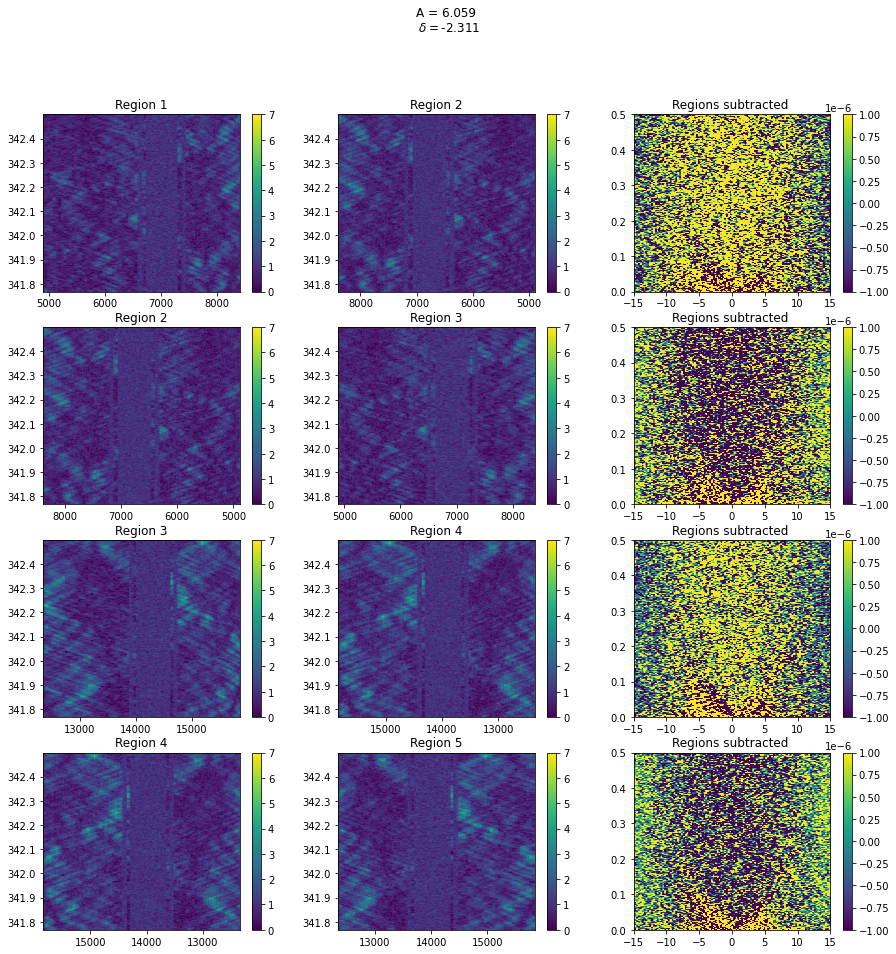

In [23]:
A_type =7
d_type = -1

counter = 0

taulimiter = .5
fdlimiter = 15
plt.figure(figsize=(15,15))

plt.suptitle("A = " + d2str(A_storage[A_type][0],3) + " \n $\delta = $" +  d2str(param_arr[A_type][d_type],3))


for i in range(len(sections_array)):
# for i in [0]:

    
    plt.subplot(len(sections_array),3,3*counter+1)

    plt.title( "Region " + str(sections_array[i][0] + 1))
    
    plt.imshow(datas[1][A_type][d_type][i][0] ,
           origin='lower',
            aspect = 'auto',
               vmin = 0,
               vmax = 7.,
           extent=ext_find(datas[0][A_type][d_type][i][0], fs))
    
    plt.colorbar()
    
    
    plt.subplot(len(sections_array),3,3*counter+2)
    plt.title( "Region " + str(sections_array[i][1] + 1))
    
    plt.imshow(datas[1][A_type][d_type][i][1] ,
           origin='lower',
               aspect = 'auto',
                vmin = 0,
               vmax = 7.,
           extent=ext_find(datas[0][A_type][d_type][i][1], fs))
    
    plt.colorbar()
    
    plt.subplot(len(sections_array),3,3*counter+3)
    plt.title( "Regions subtracted ")
    
    
    lims = 1e-6
    
    ssr1 = np.abs(datas[3][A_type][d_type][i][0] )**2
    ssr1 /= np.max(ssr1)
    
    ssr2 = np.abs(datas[3][A_type][d_type][i][1] )**2
    ssr2 /= np.max(ssr2)
    
    plt.imshow(ssr1 - np.flip(ssr2,1), 
           vmin = -lims, 
           vmax = lims,
           origin='lower',
           aspect='auto', 
           extent=ext_find( datas[2][A_type][d_type][i][1], datas[5].to(u.ms)))
    plt.colorbar()
    plt.ylim(0,taulimiter)
    plt.xlim(-fdlimiter,fdlimiter)
#     plt.axhline(y=0.09, color='red', linestyle='--', lw = 0.5)
    counter += 1

(-15.0, 15.0)

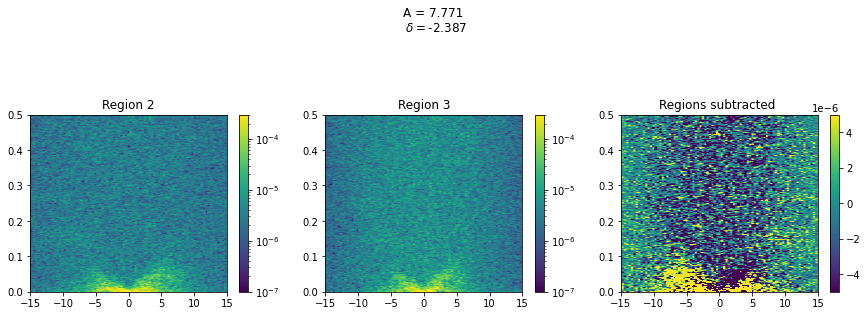

In [26]:
A_type =-1
d_type = -1

counter = 0

taulimiter = .5
fdlimiter = 15

plt.figure(figsize=(15,15))

plt.suptitle("A = " + d2str(A_storage[A_type][0],3) + " \n $\delta = $" +  d2str(param_arr[A_type][d_type],3))


k = 1

    
plt.subplot(len(sections_array),3,3*counter+1)

plt.title( "Region " + str(sections_array[k][0] + 1))

ssr1 = np.abs(datas[3][A_type][d_type][k][0] )**2
ssr1 /= np.max(ssr1)


secondary_spectrum_plotter_time2( datas[2][A_type][d_type][k][0], 
                            datas[5].to(u.ms), 
                            ssr1, 
                            1e-7, 
                            3e-4 , 
                            15, 
                            None, 
                            None)
#     plt.axhline(y=0.09, color='red', linestyle='--', lw = 0.5)
plt.ylim(0,taulimiter)
plt.xlim(-fdlimiter,fdlimiter)

plt.subplot(len(sections_array),3,3*counter+2)
plt.title( "Region " + str(sections_array[k][1] + 1))

ssr2 = np.abs(datas[3][A_type][d_type][k][1] )**2
ssr2 /= np.max(ssr2)

secondary_spectrum_plotter_time2( datas[2][A_type][d_type][k][1], 
                            datas[5].to(u.ms), 
                            ssr2, 
                            1e-7, 
                            3e-4 , 
                            15, 
                            None, 
                            None)
plt.ylim(0,taulimiter)
plt.xlim(-fdlimiter,fdlimiter)

plt.subplot(len(sections_array),3,3*counter+3)
plt.title( "Regions subtracted ")

lims = 5e-6
plt.imshow(ssr1 - ssr2, 
       vmin = -lims, 
       vmax = lims,
       origin='lower',
       aspect='auto', 
       extent=ext_find( datas[2][A_type][d_type][k][1], datas[5].to(u.ms)))
plt.colorbar()
plt.ylim(0,taulimiter)
plt.xlim(-fdlimiter,fdlimiter)
#     plt.axhline(y=0.09, color='red', linestyle='--', lw = 0.5)


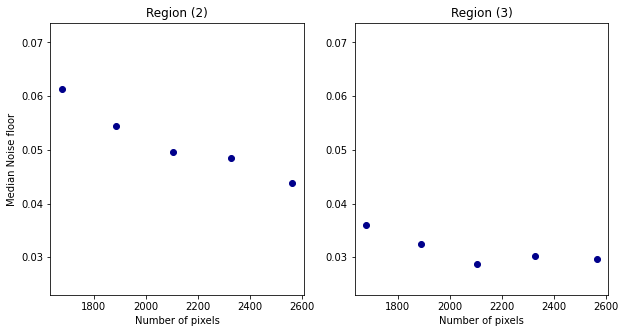

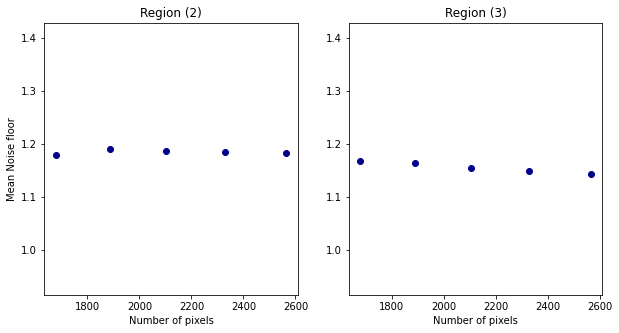

(0.022991813458876305, 0.07363036421061414)

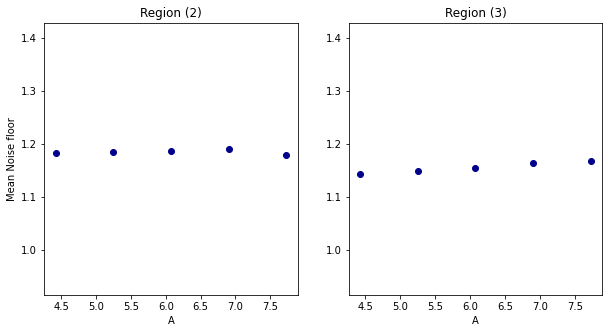

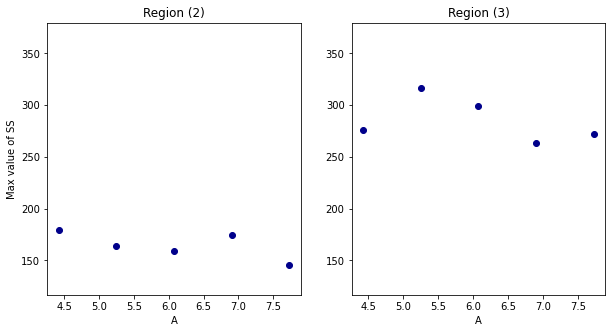

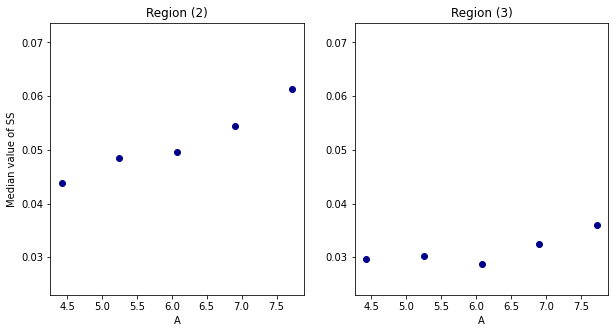

In [42]:
d_type = 0
k = 1

floorbot = 2500
floortop = 3000

alpha = 1.
beta = 0.

plt.figure(figsize = (10,5))

noise_scaler = []
plt.subplot(1,2,1)
plt.title('Region (' + str(k+1) + ')')
for i in range(len(A_storage)):
    ssntmp0 = np.abs( datas[3][i][d_type][k][0] )**2 
    ssntmp0 /= np.max( np.abs( datas[3][i][d_type][k][0] )**(alpha) )
    ssntmp0 /= np.sum(ssntmp0)**(beta)
    
    array2plot = np.median(ssntmp0[floorbot:floortop])
    plt.plot(len(datas[0][i][d_type][k][0]), array2plot,  'o', color = 'darkblue')
    
    noise_scaler += [array2plot]
    
plt.ylabel("Median Noise floor")
plt.xlabel("Number of pixels")
plt.subplot(1,2,2)
plt.title('Region (' + str(k+2) + ')')
for i in range(len(A_storage)):
    ssntmp1 = np.abs( datas[3][i][d_type][k][1] )**2
    ssntmp1 /= np.max(np.abs( datas[3][i][d_type][k][0] ))**(alpha)
    ssntmp1 /= np.sum(ssntmp1)**(beta)
    
    array2plot = np.median(ssntmp1[floorbot:floortop])
    plt.plot(len(datas[0][i][d_type][k][1]), array2plot,  'o', color = 'darkblue')
    noise_scaler += [array2plot]

plt.xlabel("Number of pixels")
plt.subplot(1,2,1)
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)
plt.subplot(1,2,2)
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)


#------mean-------------------------------------------------------------
plt.show()
plt.figure(figsize = (10,5))

noise_scaler = []
plt.subplot(1,2,1)
plt.title('Region (' + str(k+1) + ')')
for i in range(len(A_storage)):
    ssntmp0 = np.abs( datas[3][i][d_type][k][0] )**2 
    ssntmp0 /= np.max( np.abs( datas[3][i][d_type][k][0] )**(alpha) )
    ssntmp0 /= np.sum(ssntmp0)**(beta)
    
    array2plot = np.mean(ssntmp0[floorbot:floortop])
    plt.plot(len(datas[0][i][d_type][k][0]), array2plot,  'o', color = 'darkblue')
    
    noise_scaler += [array2plot]
    
plt.ylabel("Mean Noise floor")
plt.xlabel("Number of pixels")
plt.subplot(1,2,2)
plt.title('Region (' + str(k+2) + ')')
for i in range(len(A_storage)):
    ssntmp1 = np.abs( datas[3][i][d_type][k][1] )**2
    ssntmp1 /= np.max(np.abs( datas[3][i][d_type][k][0] ))**(alpha)
    ssntmp1 /= np.sum(ssntmp1)**(beta)
    
    array2plot = np.mean(ssntmp1[floorbot:floortop])
    plt.plot(len(datas[0][i][d_type][k][1]), array2plot,  'o', color = 'darkblue')
    noise_scaler += [array2plot]

plt.xlabel("Number of pixels")
plt.subplot(1,2,1)
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)
plt.subplot(1,2,2)
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)
plt.show()
# #------end of mean-------------------------------------------------------------

noise_scaler = []
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Region (' + str(k+1) + ')')

for i in range(len(A_storage)):
    ssntmp0 = np.abs( datas[3][i][d_type][k][0] )**2 
    ssntmp0 /= np.max( np.abs( datas[3][i][d_type][k][0] ))**(alpha)
    ssntmp0 /= np.sum(ssntmp0)**(beta)
    
    array2plot = np.mean(ssntmp0[floorbot:floortop])
    plt.plot(A_storage[i], array2plot,  'o', color = 'darkblue')
    noise_scaler += [array2plot]
plt.xlabel("A")    
    
plt.ylabel("Mean Noise floor")
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)


plt.subplot(1,2,2)
plt.title('Region (' + str(k+2) + ')')
for i in range(len(A_storage)):
    ssntmp1 = np.abs( datas[3][i][d_type][k][1] )**2
    ssntmp1 /= np.max(np.abs( datas[3][i][d_type][k][0] ))**(alpha)
    ssntmp1 /= np.sum(ssntmp1)**(beta)
    
    array2plot = np.mean(ssntmp1[floorbot:floortop])
    plt.plot(A_storage[i], array2plot,  'o', color = 'darkblue')
    noise_scaler += [array2plot]
    
plt.xlabel("A")
plt.subplot(1,2,1)
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)
plt.subplot(1,2,2)
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)


noise_scaler = []
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Region (' + str(k+1) + ')')

for i in range(len(A_storage)):
    ssntmp0 = np.abs( datas[3][i][d_type][k][0] )**2 
    ssntmp0 /= np.max( np.abs( datas[3][i][d_type][k][0] ))**(alpha)
    ssntmp0 /= np.sum(ssntmp0)**(beta)
    
    array2plot = np.max(ssntmp0[floorbot:floortop])
    plt.plot(A_storage[i], array2plot,  'o', color = 'darkblue')
    noise_scaler += [array2plot]
plt.xlabel("A")    
    
plt.ylabel("Max value of SS")
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)


plt.subplot(1,2,2)
plt.title('Region (' + str(k+2) + ')')
for i in range(len(A_storage)):
    ssntmp1 = np.abs( datas[3][i][d_type][k][1] )**2
    ssntmp1 /= np.max(np.abs( datas[3][i][d_type][k][0] ))**(alpha)
    ssntmp1 /= np.sum(ssntmp1)**(beta)
    
    array2plot = np.max(ssntmp1[floorbot:floortop])
    plt.plot(A_storage[i], array2plot,  'o', color = 'darkblue')
    noise_scaler += [array2plot]
    
plt.xlabel("A")
plt.subplot(1,2,1)
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)
plt.subplot(1,2,2)
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)





noise_scaler = []
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Region (' + str(k+1) + ')')

for i in range(len(A_storage)):
    ssntmp0 = np.abs( datas[3][i][d_type][k][0] )**2 
    ssntmp0 /= np.max( np.abs( datas[3][i][d_type][k][0] ))**(alpha)
    ssntmp0 /= np.sum(ssntmp0)**(beta)
    
    array2plot = np.median(ssntmp0[floorbot:floortop])
    plt.plot(A_storage[i], array2plot,  'o', color = 'darkblue')
    noise_scaler += [array2plot]
plt.xlabel("A")    
    
plt.ylabel("Median value of SS")


plt.subplot(1,2,2)
plt.title('Region (' + str(k+2) + ')')
for i in range(len(A_storage)):
    ssntmp1 = np.abs( datas[3][i][d_type][k][1] )**2
    ssntmp1 /= np.max(np.abs( datas[3][i][d_type][k][0] ))**(alpha)
    ssntmp1 /= np.sum(ssntmp1)**(beta)
    
    array2plot = np.median(ssntmp1[floorbot:floortop])
    plt.plot(A_storage[i], array2plot,  'o', color = 'darkblue')
    noise_scaler += [array2plot]
    
plt.xlabel("A")
plt.subplot(1,2,1)
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)
plt.subplot(1,2,2)
plt.ylim(np.min(noise_scaler)*0.8, np.max(noise_scaler)*1.2)

## Compute $\chi^2$

In [28]:
timer2 = timer.time()
chi_ans, chidata = chi_similar_region(data_fd = datas[2], 
                                       data_cs = datas[3], 
                                       sstrength = 10, 
                                       data_tau = datas[5].to(u.ms), 
                                       tau_min = 0.03, 
                                       tau_max = 0.2, 
                                       fdlims = 20., 
                                       fdeval = 12., 
                                       N_int = 201,
                                       alpha = 1.)

print(timer.time() - timer2 )

149.3547968864441


In [29]:
timer2 = timer.time()
chi_ans2, chidata2 = chi_similar_region(data_fd = datas2[2], 
                                       data_cs = datas2[3], 
                                       sstrength = 10, 
                                       data_tau = datas2[4].to(u.ms), 
                                       tau_min = 0.03, 
                                       tau_max = 0.2, 
                                       fdlims = 20., 
                                       fdeval = 12., 
                                       N_int = 201,
                                       alpha = 1.)

print(timer.time() - timer2 )

107.3204836845398


In [55]:
A_storage

[array([4.4244739]),
 array([5.25039825]),
 array([6.0763226]),
 array([6.90224695]),
 array([7.72817129])]

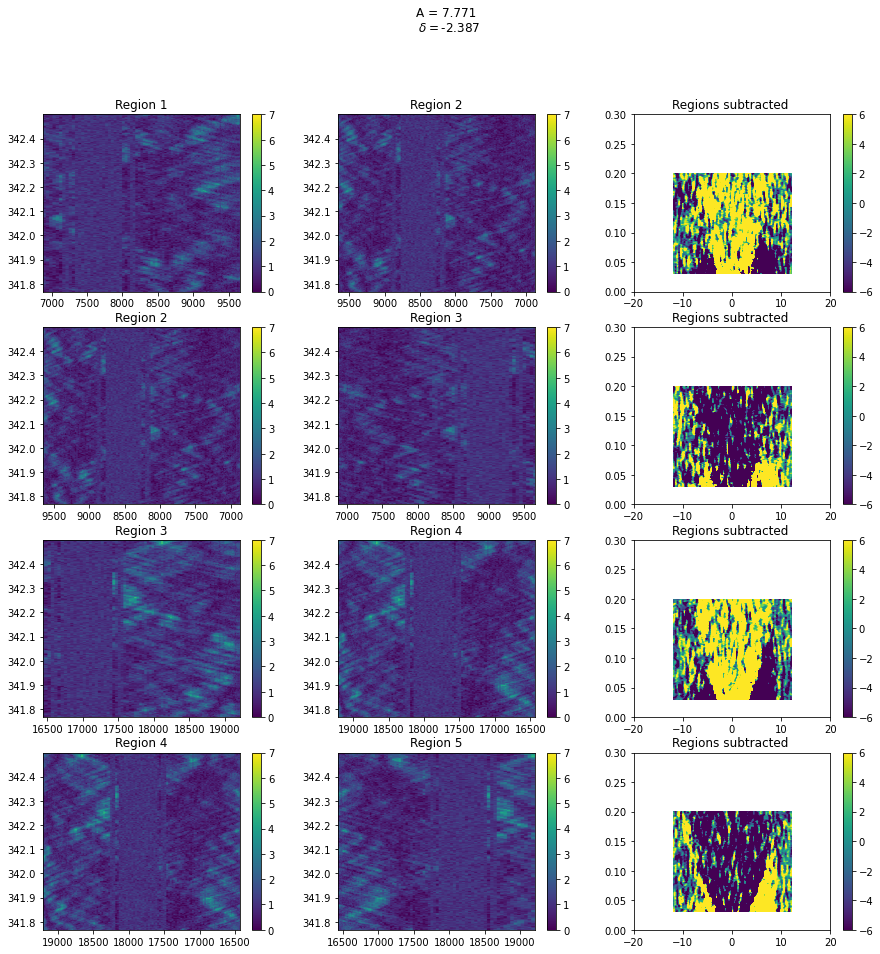

In [30]:
A_type = -1
d_type = -1

counter = 0

taulimiter = .3
fdlimiter = 20
plt.figure(figsize=(15,15))

plt.suptitle("A = " + d2str(A_storage[A_type][0],3) + " \n $\delta = $" +  d2str(param_arr[A_type][d_type],3))

for i in range(len(sections_array)):
# for i in [0]:

    
    plt.subplot(len(sections_array),3,3*counter+1)

    plt.title( "Region " + str(sections_array[i][0] + 1))
    
    plt.imshow(datas[1][A_type][d_type][i][0] ,
           origin='lower',
            aspect = 'auto',
               vmin = 0,
               vmax = 7.,
           extent=ext_find(datas[0][A_type][d_type][i][0], fs))
    
    plt.colorbar()
    
    
#     plt.axhline(y=0.09, color='red', linestyle='--', lw = 0.5)
    
    
    plt.subplot(len(sections_array),3,3*counter+2)
    plt.title( "Region " + str(sections_array[i][1] + 1))
    
    plt.imshow(datas[1][A_type][d_type][i][1] ,
           origin='lower',
               aspect = 'auto',
                vmin = 0,
               vmax = 7.,
           extent=ext_find(datas[0][A_type][d_type][i][1], fs))
    
    plt.colorbar()
    
    plt.subplot(len(sections_array),3,3*counter+3)
    plt.title( "Regions subtracted ")
    
    
    lims = 6
    
    ssr1 = chidata[A_type][d_type][i][2]
    ssr2 = chidata[A_type][d_type][i][3]
    
    
    plt.imshow(ssr1 - ssr2, 
           vmin = -lims, 
           vmax = lims,
           origin='lower',
           aspect='auto', 
           extent=ext_find( chidata[A_type][d_type][i][0], chidata[A_type][d_type][i][1].to(u.ms)))
    plt.colorbar()
    plt.ylim(0,taulimiter)
    plt.xlim(-fdlimiter,fdlimiter)
#     plt.axhline(y=0.09, color='red', linestyle='--', lw = 0.5)
    counter += 1

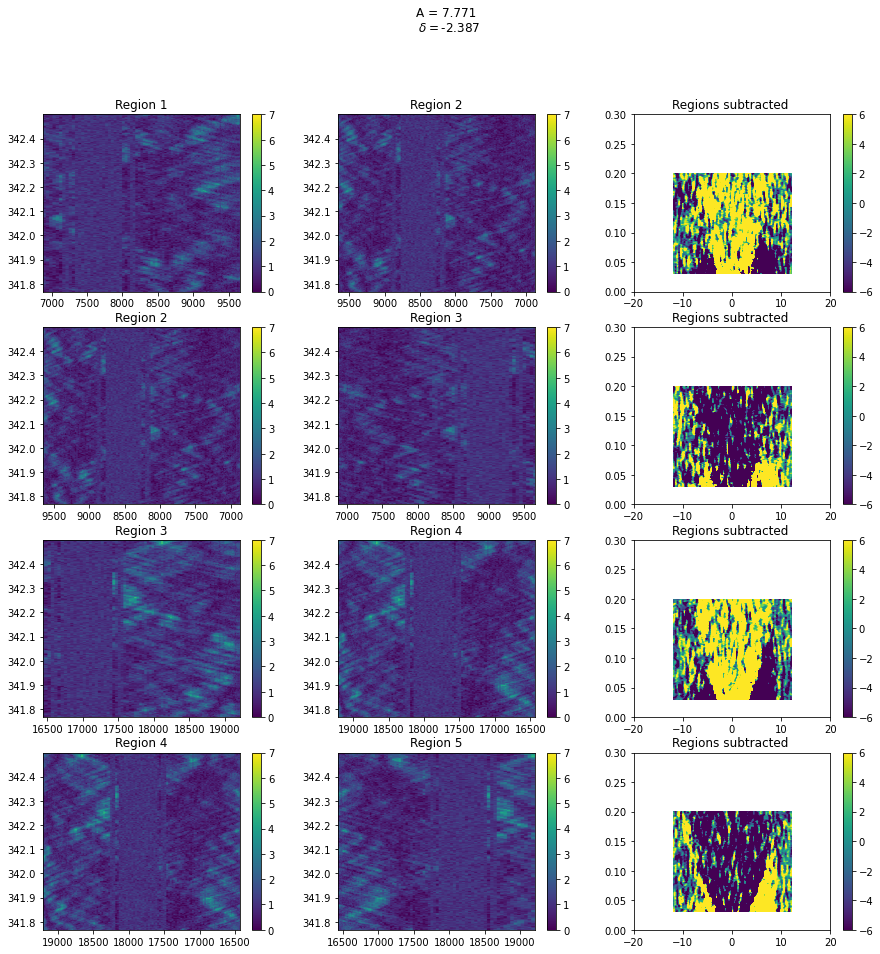

In [31]:
A_type = -1
d_type = -1

counter = 0

taulimiter = .3
fdlimiter = 20
plt.figure(figsize=(15,15))

plt.suptitle("A = " + d2str(A_storage[A_type][0],3) + " \n $\delta = $" +  d2str(param_arr[A_type][d_type],3))

for i in range(len(sections_array)):
# for i in [0]:

    
    plt.subplot(len(sections_array),3,3*counter+1)

    plt.title( "Region " + str(sections_array[i][0] + 1))
    
    plt.imshow(datas2[1][A_type][d_type][i][0] ,
           origin='lower',
            aspect = 'auto',
               vmin = 0,
               vmax = 7.,
           extent=ext_find(datas2[0][A_type][d_type][i][0], fs))
    
    plt.colorbar()
    
    
#     plt.axhline(y=0.09, color='red', linestyle='--', lw = 0.5)
    
    
    plt.subplot(len(sections_array),3,3*counter+2)
    plt.title( "Region " + str(sections_array[i][1] + 1))
    
    plt.imshow(datas2[1][A_type][d_type][i][1] ,
           origin='lower',
               aspect = 'auto',
                vmin = 0,
               vmax = 7.,
           extent=ext_find(datas2[0][A_type][d_type][i][1], fs))
    
    plt.colorbar()
    
    plt.subplot(len(sections_array),3,3*counter+3)
    plt.title( "Regions subtracted ")
    
    
    lims = 6
    
    ssr1 = chidata2[A_type][d_type][i][2]
    ssr2 = chidata2[A_type][d_type][i][3]
    
    
    plt.imshow(ssr1 - ssr2, 
           vmin = -lims, 
           vmax = lims,
           origin='lower',
           aspect='auto', 
           extent=ext_find( chidata2[A_type][d_type][i][0], chidata2[A_type][d_type][i][1].to(u.ms)))
    plt.colorbar()
    plt.ylim(0,taulimiter)
    plt.xlim(-fdlimiter,fdlimiter)
#     plt.axhline(y=0.09, color='red', linestyle='--', lw = 0.5)
    counter += 1

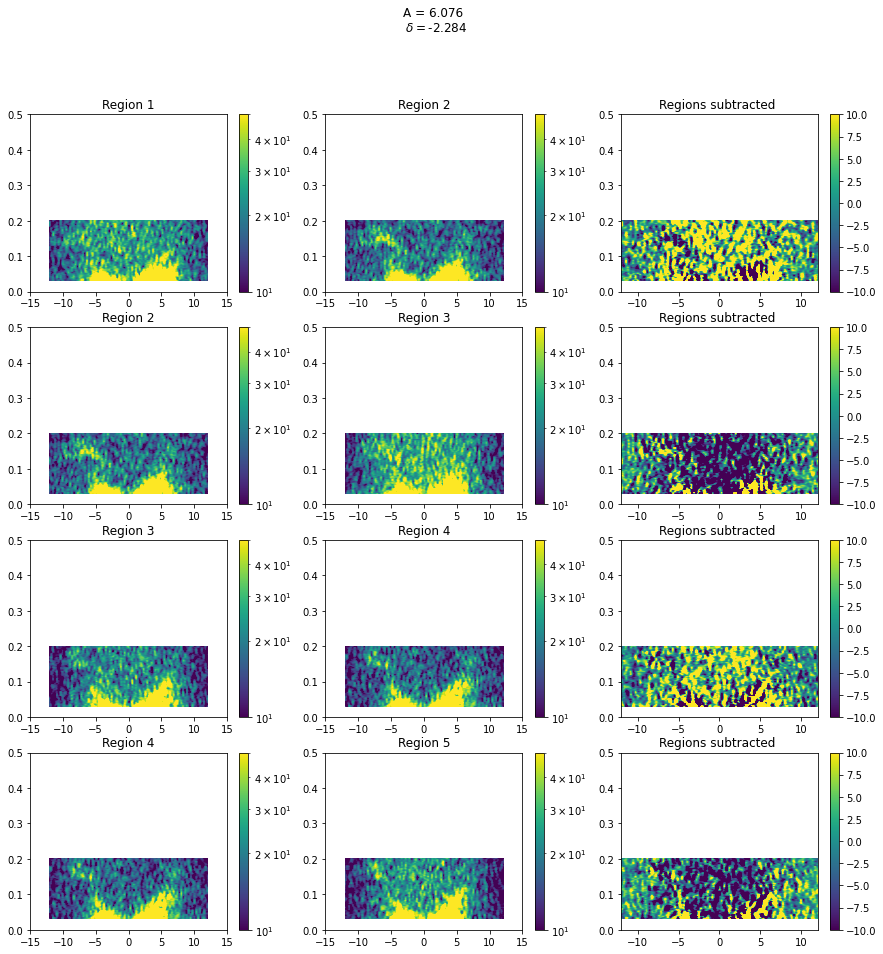

In [75]:
A_type =2
d_type = -1

counter = 0

taulimiter = 0.5
plt.figure(figsize=(15,15))

plt.suptitle("A = " + d2str(A_storage[A_type][0],3) + " \n $\delta = $" +  d2str(param_arr[A_type][d_type],3))

for i in range(len(sections_array)):
    
    
    plt.subplot(len(sections_array),3,3*counter+1)

    plt.title( "Region " + str(sections_array[i][0] + 1))
    
    secondary_spectrum_plotter_time2( chidata[A_type][d_type][i][0], 
                                    chidata[A_type][d_type][i][1], 
                                    chidata[A_type][d_type][i][2], 
                                    1e1, 
                                    5e1 , 
                                    15, 
                                    None, 
                                    None)
#     plt.axhline(y=0.09, color='red', linestyle='--', lw = 0.5)
    plt.ylim(0,taulimiter)
    
    
    plt.subplot(len(sections_array),3,3*counter+2)
    plt.title( "Region " + str(sections_array[i][1] + 1))
    
    secondary_spectrum_plotter_time2( chidata[A_type][d_type][i][0], 
                                    chidata[A_type][d_type][i][1], 
                                    chidata[A_type][d_type][i][3], 
                                    1e1, 
                                    5e1 , 
                                    15, 
                                    None, 
                                    None)
    plt.ylim(0,taulimiter)
    
    
    plt.subplot(len(sections_array),3,3*counter+3)
    plt.title( "Regions subtracted ")
    

    lims = 1e1
    plt.imshow(chidata[A_type][d_type][i][2] - chidata[A_type][d_type][i][3], 
           vmin = -lims, 
           vmax = lims,
           origin='lower',
           aspect='auto', 
           extent=ext_find( chidata[A_type][d_type][i][0], chidata[A_type][d_type][i][1]))
    plt.colorbar()
    plt.ylim(0,taulimiter)
#     plt.axhline(y=0.09, color='red', linestyle='--', lw = 0.5)
    counter += 1

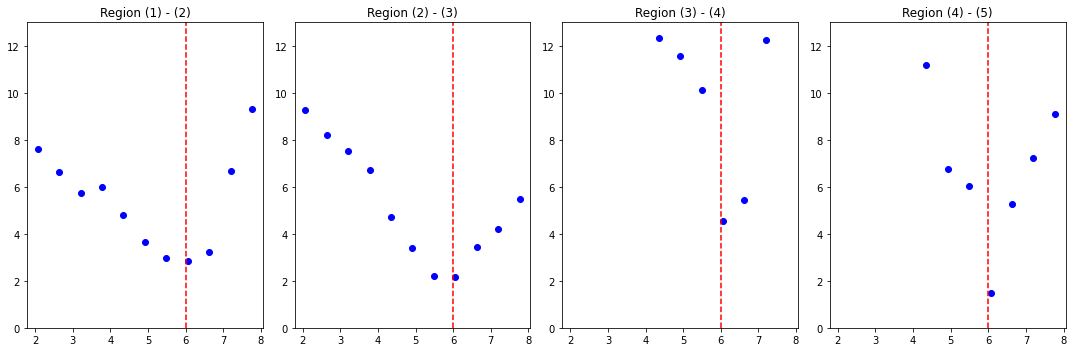

In [46]:
plt.figure(figsize = (15,5))
j = -1
for k in range(4):

    for i in range(len(A_storage)):


        norm_fac = chidata[i][j][k][2].shape[0] * chidata[i][j][k][2].shape[1] * (np.std(chidata[i][j][k][2][-5:-1])**2 +  np.std(chidata[i][j][k][3][-5:-1])**2 )

        sumtmp = np.sum( np.square( chidata[i][j][k][2] 
                                   - chidata[i][j][k][3]  ) )  / norm_fac
        plt.subplot(1,4,k+1)
        plt.tight_layout()
        plt.plot(A_storage[i], sumtmp, 'bo')
        plt.title("Region (" + str(k+1)+ ") - (" + str(k+2) + ")" )
        plt.ylim(0, 13.)
        
    plt.axvline(x=A, color='r', linestyle='--')
#         plt.ylim(0.5, 2.)


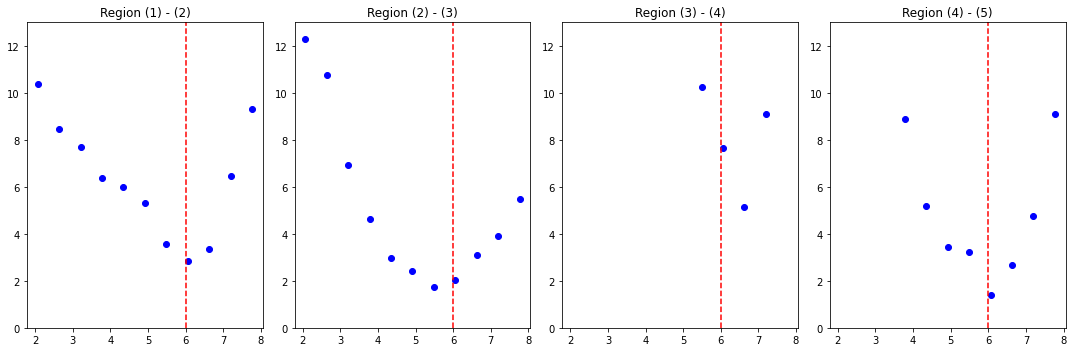

In [50]:
plt.figure(figsize = (15,5))
j = -1
for k in range(4):

    for i in range(len(A_storage)):


        norm_fac = chidata2[i][j][k][2].shape[0] * chidata2[i][j][k][2].shape[1] * (np.std(chidata2[i][j][k][2][-5:-1])**2 +  np.std(chidata2[i][j][k][3][-5:-1])**2 )

        sumtmp = np.sum( np.square( chidata2[i][j][k][2] 
                                   - chidata2[i][j][k][3]  ) )  / norm_fac
        plt.subplot(1,4,k+1)
        plt.tight_layout()
        plt.plot(A_storage[i], sumtmp, 'bo')
        plt.title("Region (" + str(k+1)+ ") - (" + str(k+2) + ")" )
        plt.ylim(0, 13.)
        
    plt.axvline(x=A, color='r', linestyle='--')
        


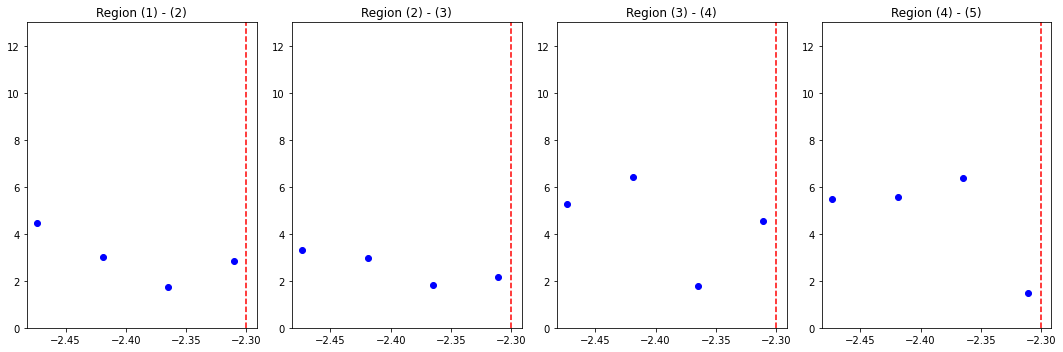

In [48]:
plt.figure(figsize = (15,5))
i  = 7
for k in range(4):

    for j in range(len(param_arr[7])):


        norm_fac = chidata[i][j][k][2].shape[0] * chidata[i][j][k][2].shape[1] * (np.std(chidata[i][j][k][2][-5:-1])**2 +  np.std(chidata[i][j][k][3][-5:-1])**2 )

        sumtmp = np.sum( np.square( chidata[i][j][k][2] 
                                   - chidata[i][j][k][3]  ) )  / norm_fac
        plt.subplot(1,4,k+1)
        plt.tight_layout()
        plt.plot(param_arr[7][j], sumtmp, 'bo')
        plt.title("Region (" + str(k+1)+ ") - (" + str(k+2) + ")" )
        plt.ylim(0, 13.)
        
    plt.axvline(x=c, color='r', linestyle='--')

In [90]:
chi_grid = []

for k in range(len( sections_array )):
    chi_grid_tmpk = []
    
    for i in range(len(A_storage)):
        chi_grid_tmpi = []
        
        for j in range(len(param_arr[i])):

            norm_fac = chidata[i][j][k][2].shape[0] * chidata[i][j][k][2].shape[1] * (np.std(chidata[i][j][k][2][-5:-1])**2 +  np.std(chidata[i][j][k][3][-5:-1])**2 )

            sumtmp = np.sum( np.square( chidata[i][j][k][2] 
                                       - chidata[i][j][k][3]  ) )  / norm_fac
            
            chi_grid_tmpi += [sumtmp]
        
        chi_grid_tmpk += [chi_grid_tmpi]
        
    chi_grid += [chi_grid_tmpk]

In [91]:
chi_grid2 = []

for k in range(len( sections_array )):
    chi_grid_tmpk = []
    
    for i in range(len(A_storage)):
        chi_grid_tmpi = []
        
        for j in range(len(param_arr[i])):

            norm_fac = chidata2[i][j][k][2].shape[0] * chidata2[i][j][k][2].shape[1] * (np.std(chidata2[i][j][k][2][-5:-1])**2 +  np.std(chidata2[i][j][k][3][-5:-1])**2 )

            sumtmp = np.sum( np.square( chidata2[i][j][k][2] 
                                       - chidata2[i][j][k][3]  ) )  / norm_fac
            
            chi_grid_tmpi += [sumtmp]
        
        chi_grid_tmpk += [chi_grid_tmpi]
        
    chi_grid2 += [chi_grid_tmpk]

In [92]:
for k in range(len( sections_array )):

    ansstor2 = np.zeros(len(chi_grid[k]))
    for i in range(len(chi_grid[k])):
        ansstor2[i] = np.min( np.array(chi_grid[k][i]) )

    aind = np.where( ansstor2 == np.min(ansstor2))[0][0]
    dind = np.where(chi_grid[k][aind] == np.min(chi_grid[k][aind]))[0][0]

    print("Region (" + str(k+1) + "- " + str(k+2) + ") best params"  )
    print("------------------------------")
    print("A     = ", A_storage[aind][0])
    print("delta = ", param_arr[aind][dind])
    print("")

Region (1- 2) best params
------------------------------
A     =  6.059266756197568
delta =  -2.364824120603015

Region (2- 3) best params
------------------------------
A     =  6.059266756197568
delta =  -2.364824120603015

Region (3- 4) best params
------------------------------
A     =  6.059266756197568
delta =  -2.364824120603015

Region (4- 5) best params
------------------------------
A     =  6.059266756197568
delta =  -2.3105527638190955



In [93]:
for k in range(len( sections_array )):

    ansstor2 = np.zeros(len(chi_grid2[k]))
    for i in range(len(chi_grid2[k])):
        ansstor2[i] = np.min( np.array(chi_grid2[k][i]) )

    aind = np.where( ansstor2 == np.min(ansstor2))[0][0]
    dind = np.where(chi_grid2[k][aind] == np.min(chi_grid2[k][aind]))[0][0]

    print("Region (" + str(k+1) + "- " + str(k+2) + ") best params"  )
    print("------------------------------")
    print("A     = ", A_storage[aind][0])
    print("delta = ", param_arr[aind][dind])
    print("")

Region (1- 2) best params
------------------------------
A     =  6.059266756197568
delta =  -2.364824120603015

Region (2- 3) best params
------------------------------
A     =  6.059266756197568
delta =  -2.364824120603015

Region (3- 4) best params
------------------------------
A     =  6.059266756197568
delta =  -2.364824120603015

Region (4- 5) best params
------------------------------
A     =  6.059266756197568
delta =  -2.3105527638190955



In [81]:
print("Region (" + str(k+1) + "- " + str(k+2) + ") best params"  )

Region (1- 2) best params


In [77]:
A_storage[aind]

array([6.05926676])

In [78]:
param_arr[aind][dind]

-2.364824120603015

In [67]:
np.zeros(len(chi_grid[0]))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [72]:
chi_grid[k][3]

[15.656768018679555, 15.819898136822271, 15.694252492375668]

In [44]:
from scipy.signal import convolve2d
from scipy.stats import norm
from scipy.optimize import curve_fit

def vertical_rolling_average(A, b):
    # Define the vertical kernel for convolution
    kernel = np.ones((b, 1), dtype=np.float64) / b
    
    # Apply convolution along the rows (vertical direction)
    result = convolve2d(A, kernel, mode='same', boundary='symm')
    
    return result

In [45]:
def chi_similar_region(data_fd, data_cs, sstrength, data_tau, tau_min, tau_max, fdlims, fdeval, N_int, alpha):
    """
    Function to take two pairs of regions from data in 
    fd data_fd
    taud data_tau
    and conjugate spectrum data_cs
    
    compute the secondary spectrum for each region, scale each region by max(|CS|)^alpha
    apply a rolling average filter with sstrengh (sstrength indicates how many rows to average)
    crop the secondary spectrum by tau_min and tau_max
    interpolate and crop the secondary spectra in fd in (-fdeval, fdeval) with N_int elements
    
    return sum( (Sspec_i - Sspec_j)^2) and the correspodning fd, taud, and Sspec for both regions ij
    """
    
    
    chi_tmp = []
    plotter_tmp = []
    
    #loop over A
    for i in range(len(data_fd)):
        
        #loop over the phase
        chi_tmp_phase = []
        plotter_tmp_phase = []

        for j in range(len(data_fd[i])):
        
            regions_tmp = np.zeros(len(data_fd[0][0]))
            
            plotter_tmp2 = []
            
            #loop over the different regions
            for k in range(len(data_fd[0][0])):

                fd1_tmp = data_fd[i][j][k][0]
                fd2_tmp = data_fd[i][j][k][1]

                ss1_tmp = (np.abs(data_cs[i][j][k][0])**2) / np.max(np.abs(data_cs[i][j][k][0])**alpha)
                ss2_tmp = (np.abs(data_cs[i][j][k][1])**2) / np.max(np.abs(data_cs[i][j][k][1])**alpha)

                ss1 = vertical_rolling_average(ss1_tmp, sstrength)
                ss2 = vertical_rolling_average(ss2_tmp, sstrength)

                index = find_indices_within_range(data_tau.value, tau_min, tau_max )


                SS_int1, fd_int = interpolate_and_evaluate(x0 = fd1_tmp, 
                                                         SS = ss1[index] , #* data_tau[index, np.newaxis].value, 
                                                         xlims = fdlims, 
                                                         xint_range = fdeval, 
                                                         N = N_int,
                                                         kind = 'quadratic')

                SS_int2, fd_int = interpolate_and_evaluate(x0 = fd2_tmp, 
                                                         SS = ss2[index] ,# * data_tau[index, np.newaxis].value, 
                                                         xlims = fdlims,
                                                         xint_range = fdeval,
                                                         N = N_int,
                                                         kind = 'quadratic')

                #-----------------------------------------------------------------------------------------
    #             SS_int1 -= np.median(SS_int1)
#                 SS_int1 /= np.sum(SS_int1)

    #             SS_int2 -= np.median(SS_int2)
#                 SS_int2 /= np.sum(SS_int2)    
                
                #regions_tmp[k] = np.sum( np.abs( SS_int1 - np.flip(SS_int2,1) )**2)
                regions_tmp[k] = np.sum( np.abs( SS_int1 - SS_int2 )**2)
                plotter_tmp2 += [[fd_int,   data_tau[index], SS_int1, SS_int2]]
                
            chi_tmp_phase += [regions_tmp]
            plotter_tmp_phase += [plotter_tmp2 ]
        
        chi_tmp += [ chi_tmp_phase ]
        plotter_tmp += [plotter_tmp_phase]
        
    return chi_tmp, plotter_tmp

## Demo of resampling given A and delta

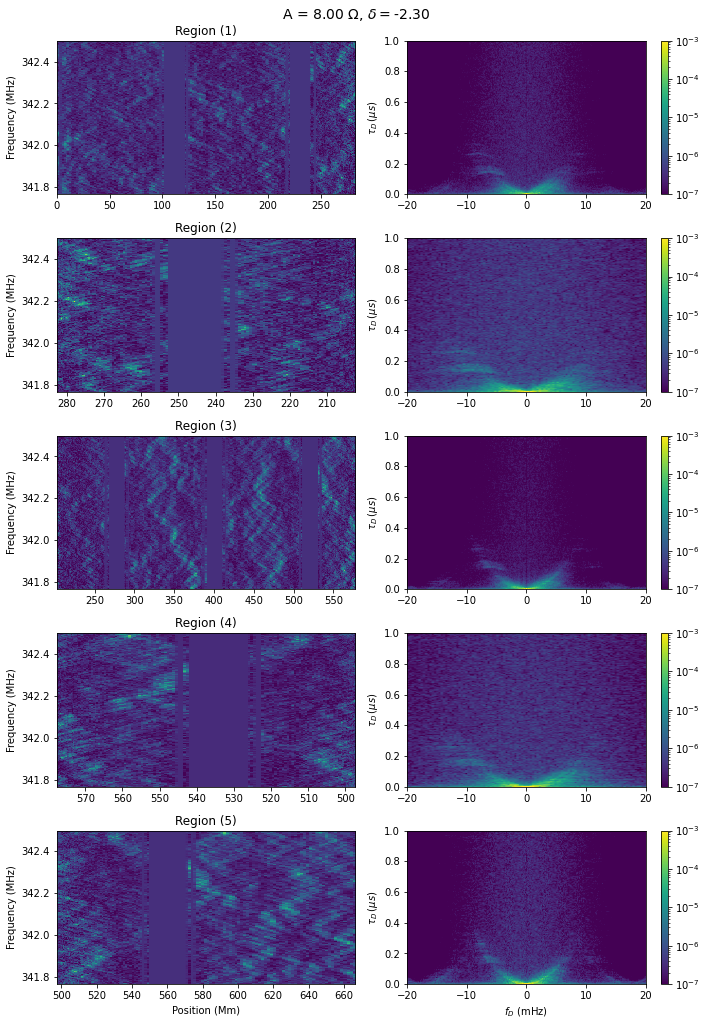

In [29]:
plotter_given_Ad2( A = 8.,
                 c = c,
                 time0 = tres2,
                 nu = nues,
                  phase = phases,
                 dyn2 = dres2,
                  freq = fs, 
                  vmin = 1e-7,
                  vmax = 1e-3,
                  aaa = tres2[peaksres].value,
                  atol = 0.03,
                  fmax = 20,
                  dynmin = np.min(dres2),
                  dynmax = np.max(dres2),
                  taumax = 1.,
                  delt = 0.05
                 )